In [2]:
import sys
if '/home/ross/immunova' not in sys.path:
    sys.path.append('/home/ross/immunova')
from immunova.data.fcs_experiments import FCSExperiment
from immunova.data.utilities import get_fcs_file_paths
from immunova.data.panel import Panel
from immunova.flow.gating.actions import Gating, Template
from immunova.flow.gating.defaults import ChildPopulationCollection
from immunova.data.mongo_setup import pd_test_init
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd_test_init()

<h1>Loading Data</h1>

<h2>T Panel Example</h2>

In [ ]:
t_panel = Panel()
t_panel.panel_name = 'PD_T'
t_panel.create_from_excel('peritonitis_t_template.xlsx')
t_panel.save()

In [4]:
t = FCSExperiment()
t.experiment_id = 'PD_T'
t.panel = t_panel
t.save()

<FCSExperiment: FCSExperiment object>

In [6]:
file_dir='/media/ross/FCS_DATA/Raya PD/31072019  T-Panel 312-01 Peritonitis'
ctrls = ['CXCR3', 'CCR7', 'CD45RA', 'CD27']
t_files = get_fcs_file_paths(file_dir, control_names=ctrls, ctrl_id='FMO')

In [7]:
t_files

{'primary': ['/media/ross/FCS_DATA/Raya PD/31072019  T-Panel 312-01 Peritonitis/T Cell Panel_312-01 PDMC T1_014.fcs'],
 'controls': [{'control_id': 'CXCR3',
   'path': '/media/ross/FCS_DATA/Raya PD/31072019  T-Panel 312-01 Peritonitis/T Cell Panel_312-01 PDMC T2 FMO CXCR3_015.fcs'},
  {'control_id': 'CCR7',
   'path': '/media/ross/FCS_DATA/Raya PD/31072019  T-Panel 312-01 Peritonitis/T Cell Panel_312-01 PDMC T3 FMO CCR7_016.fcs'},
  {'control_id': 'CD45RA',
   'path': '/media/ross/FCS_DATA/Raya PD/31072019  T-Panel 312-01 Peritonitis/T Cell Panel_312-01 PDMC T4 FMO CD45RA_017.fcs'},
  {'control_id': 'CD27',
   'path': '/media/ross/FCS_DATA/Raya PD/31072019  T-Panel 312-01 Peritonitis/T Cell Panel_312-01 PDMC T5 FMO CD27_018.fcs'}]}

In [8]:
t.add_new_sample(sample_id='PD31201', file_path=t_files['primary'][0],
                 controls=t_files['controls'], feedback=True)

Generating main file entry...
Generating file entries for controls...
Missing channel FSC-W
Missing channel FSC-W
Missing channel FSC-W
Missing channel FSC-W
Successfully created PD31201 and associated to PD_T


'5dbae6e7425b26504d59accb'

<h2>NM Panel Example</h2>

In [9]:
n_panel = Panel()
n_panel.panel_name = 'PD_N'
n_panel.create_from_excel('peritonitis_m_template.xlsx')
n_panel.save()

<Panel: Panel object>

In [10]:
n = FCSExperiment()
n.experiment_id = 'PD_N'
n.panel = n_panel
n.save()

<FCSExperiment: FCSExperiment object>

In [11]:
file_dir='/media/ross/FCS_DATA/Raya PD/31072019  N-Panel 312-01 Peritonitis'
ctrls = ['CD1c', 'HLADR']
n_files = get_fcs_file_paths(file_dir, control_names=ctrls, ctrl_id='FMO')

In [12]:
n_files

{'primary': ['/media/ross/FCS_DATA/Raya PD/31072019  N-Panel 312-01 Peritonitis/1 N Panel_312-01 PDMC N1_013.fcs'],
 'controls': [{'control_id': 'CD1c',
   'path': '/media/ross/FCS_DATA/Raya PD/31072019  N-Panel 312-01 Peritonitis/1 N Panel_312-01 PDMC N2 FMO CD1c_014.fcs'},
  {'control_id': 'HLADR',
   'path': '/media/ross/FCS_DATA/Raya PD/31072019  N-Panel 312-01 Peritonitis/1 N Panel_PD 312-01 PDMC N3 FMO HLADR_015.fcs'}]}

In [13]:
n.add_new_sample(sample_id='PD31201', file_path=n_files['primary'][0],
                 controls=n_files['controls'], feedback=True)

Generating main file entry...
Generating file entries for controls...
Successfully created PD31201 and associated to PD_N


'5dbae7be425b26504d59cc27'

<h1>Gating T Panel</h1>

In [35]:
t = FCSExperiment.objects(experiment_id='PD_T').get()

In [36]:
pdt = Template(t, 'PD31201')

In [39]:
pdt.data.columns

Index(['FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 'CXCR3', 'CD161',
       'CD3', 'CCR7', 'L/D', 'Va7.2', 'CD8', 'Vd2', 'CD45RA', 'PanGD', 'CD4',
       'CD27', 'Time'],
      dtype='object')

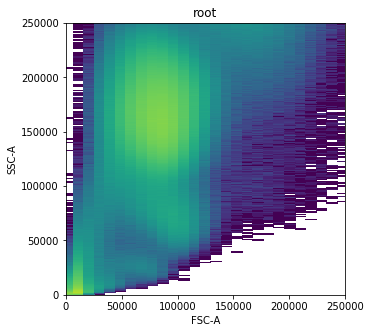

In [40]:
pdt.plotting.plot_population('root', 'FSC-A', 'SSC-A')

In [41]:
child_populations = ChildPopulationCollection('geom')
child_populations.add_population('cells', definition='+')
child_populations.add_population('debris', definition='-')

gate_definition = dict(x='FSC-A', y='SSC-A', x_min=0, x_max=150000, y_min=0, y_max=100000,
                      transform_x=None, transform_y=None)
pdt.create_gate(gate_name='boundary_gate', parent='root', class_='Static', method='rect_gate',
                kwargs=gate_definition, child_populations=child_populations)

True

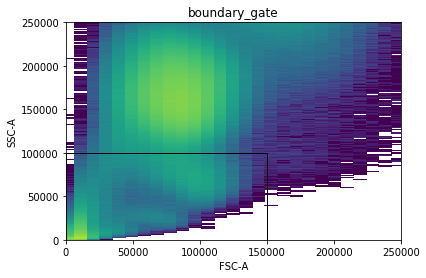

In [42]:
pdt.apply('boundary_gate')

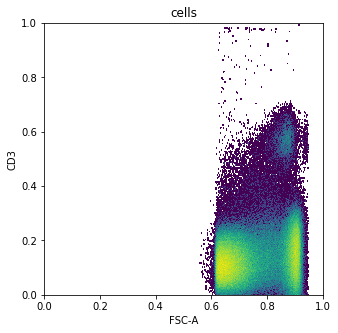

In [10]:
pdt.plotting.plot_population('cells', 'FSC-A', 'CD3', transform_y='logicle', transform_x='logicle', xlim=[0,1])

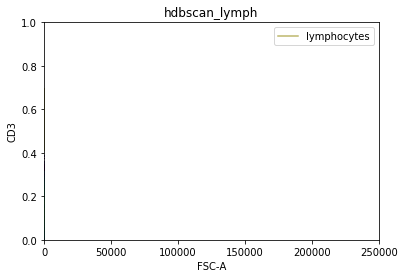

In [43]:
child_populations = ChildPopulationCollection('cluster')
child_populations.add_population('lymphocytes', target=(0.9, 0.6), weight=1)
gate_definition = dict(x='FSC-A', y='CD3', min_pop_size=100, frac=0.05)
pdt.create_gate(gate_name='hdbscan_lymph', parent='cells', class_='DensityBasedClustering', method='hdbscan',
                kwargs=gate_definition, child_populations=child_populations)
pdt.apply('hdbscan_lymph')

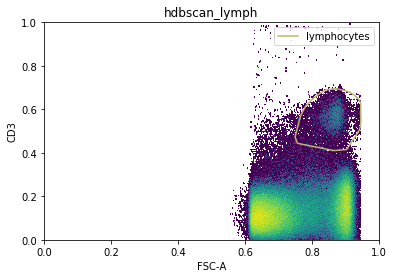

In [44]:
pdt.plotting.plot_gate('hdbscan_lymph', xlim=[0,1])

In [45]:
child_populations = ChildPopulationCollection('geom')
child_populations.add_population('singlets1', definition='+')
child_populations.add_population('doublets1', definition='-')
gate_definition = dict(x='FSC-A', y='FSC-H', target=(70000, 65000), k=1, conf=0.99, 
                       transform_x=None, transform_y=None)
pdt.create_gate(gate_name='gmm_singlets1', parent='lymphocytes', class_='MixtureModel', method='gate',
                kwargs=gate_definition, child_populations=child_populations)

True

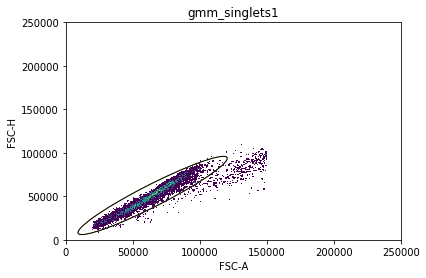

In [46]:
pdt.apply('gmm_singlets1')

In [47]:
child_populations = ChildPopulationCollection('geom')
child_populations.add_population('singlets2', definition='+')
child_populations.add_population('doublets2', definition='-')
gate_definition = dict(x='FSC-A', y='SSC-W', target=(70000, 65000), k=1, conf=0.99, 
                       transform_x=None, transform_y=None)
pdt.create_gate(gate_name='gmm_singlets2', parent='singlets1', class_='MixtureModel', method='gate',
                kwargs=gate_definition, child_populations=child_populations)

True

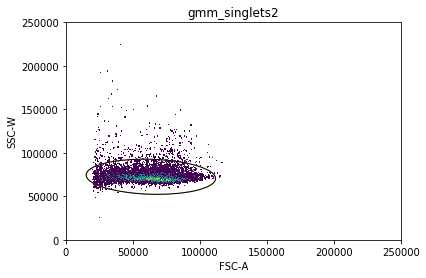

In [48]:
pdt.apply('gmm_singlets2')

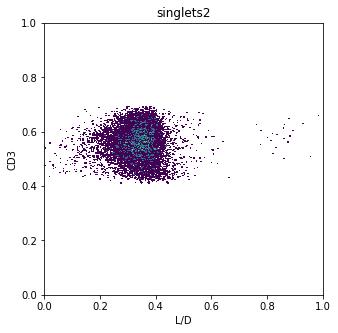

In [49]:
pdt.plotting.plot_population('singlets2', 'L/D', 'CD3', transform_x='logicle', transform_y='logicle')

In [50]:
child_populations = ChildPopulationCollection('threshold_1d')
child_populations.add_population('dead', definition='+')
child_populations.add_population('live', definition='-')
gate_definition = dict(x='L/D', y='CD3', kde_bw=0.1, peak_threshold=0.05)
pdt.create_gate(gate_name='density_liveCD3', parent='singlets2', class_='DensityThreshold', 
                 method='gate_1d', kwargs=gate_definition, child_populations=child_populations)

True

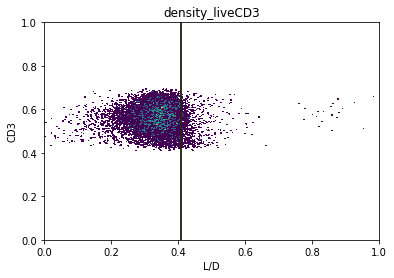

In [51]:
pdt.apply('density_liveCD3')

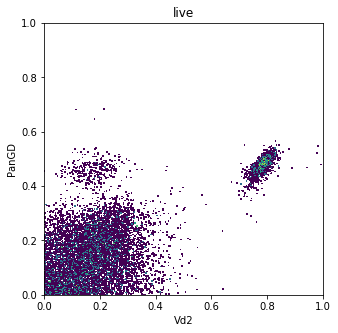

In [52]:
pdt.plotting.plot_population('live', 'Vd2', 'PanGD', transform_x='logicle', transform_y='logicle')

In [53]:
child_populations = ChildPopulationCollection('cluster')
child_populations.add_population('gdt', target=(0.8, 0.4), weight=1)
child_populations.add_population('nongdt', target=(0.2, 0.2), weight=1)
child_populations.add_population('vd2Neg', target=(0.2, 0.5), weight=2)
gate_definition = dict(x='Vd2', y='PanGD', min_pop_size=50)
pdt.create_gate(gate_name='hdbscan_gdt', parent='live', class_='DensityBasedClustering', 
                 method='hdbscan', kwargs=gate_definition, child_populations=child_populations)

True

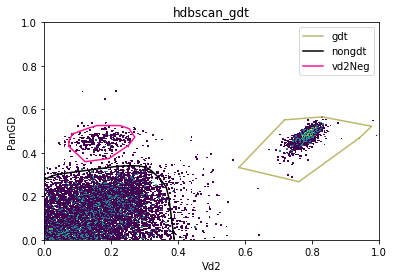

In [54]:
pdt.apply('hdbscan_gdt')

<h2>High-Dim Clustering</h2>

In [55]:
import umap
import phenograph

In [56]:
live_cd3 = pdt.get_population_df('live', transform=True, transform_features='all')

In [57]:
live_cd3.shape

(16674, 19)

In [58]:
live_cd3.drop('Time', axis=1, inplace=True)

In [59]:
live_cd3.columns

Index(['FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 'CXCR3', 'CD161',
       'CD3', 'CCR7', 'L/D', 'Va7.2', 'CD8', 'Vd2', 'CD45RA', 'PanGD', 'CD4',
       'CD27'],
      dtype='object')

In [60]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(live_cd3)
live_cd3['umap0'] = embedding[:, 0]
live_cd3['umap1'] = embedding[:, 1]

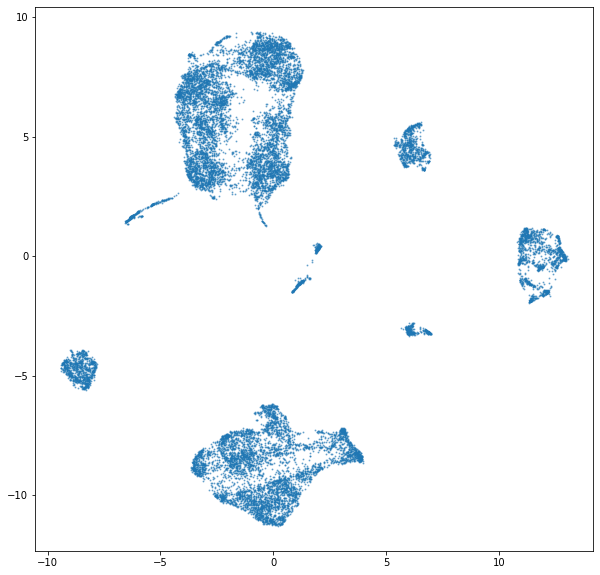

In [61]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(live_cd3['umap0'], live_cd3['umap1'], s=1, alpha=0.5)
fig.show()

In [62]:
features = [x for x in live_cd3.columns if x not in ['umap0', 'umap1']]
communities, graph, Q = phenograph.cluster(live_cd3[features])

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.2168803215026855 seconds
Jaccard graph constructed in 1.2965068817138672 seconds
Wrote graph to binary file in 0.8378238677978516 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.878995
After 21 runs, maximum modularity is Q = 0.880131
Louvain completed 41 runs in 14.511608839035034 seconds
PhenoGraph complete in 17.894717693328857 seconds


In [63]:
live_cd3['cluster'] = communities

In [64]:
len(plt.get_cmap('tab20c').colors[0:18])

18

In [65]:
len(live_cd3['cluster'].unique())

18

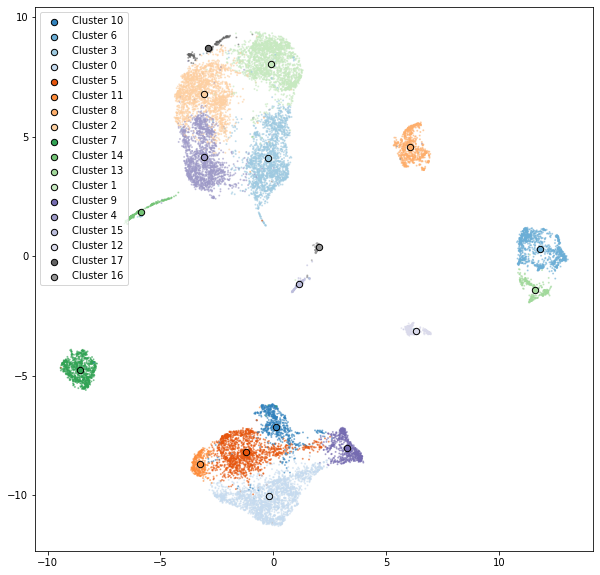

In [66]:
import seaborn as sns
from immunova.flow.gating.utilities import centroid
fig, ax = plt.subplots(figsize=(10,10))
colours = plt.get_cmap('tab20c').colors[0:18]
colour_dict = {k: v for k, v in zip(live_cd3['cluster'].unique(), colours)}
ax.scatter(live_cd3['umap0'],live_cd3['umap1'], 
           s=1, alpha=0.5, c=live_cd3['cluster'].apply(lambda x: colour_dict[x]))
for label, colour in colour_dict.items():
    d = live_cd3[live_cd3['cluster'] == label]
    center = centroid(d[['umap0', 'umap1']].values)
    ax.scatter(center[0], center[1], s=40, c=[colour], label=f'Cluster {label}', 
               linewidth=1, edgecolors='black')
ax.legend()
fig.show()

In [67]:
mfi_summary = live_cd3.groupby(by='cluster').mean()

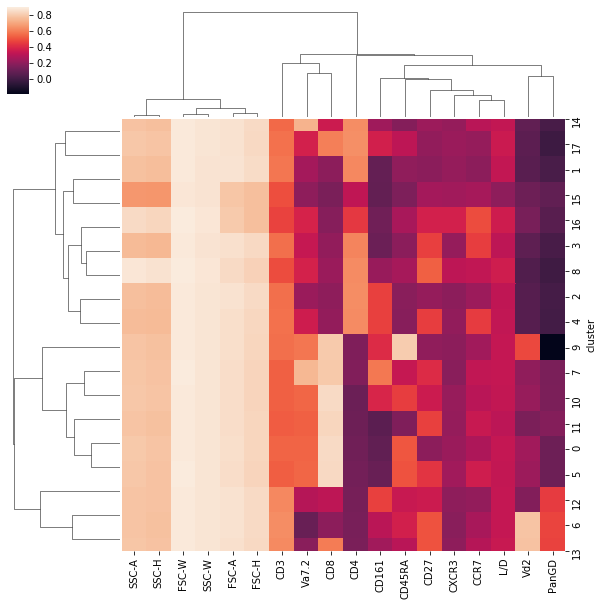

In [68]:
sns.clustermap(mfi_summary[features])

<h2>N Panel Gating</h2>

In [69]:
n = FCSExperiment.objects(experiment_id='PD_N').get()

In [70]:
pdn = Template(n, 'PD31201')

In [71]:
pdn.data.columns

Index(['FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 'CD14', 'CD16',
       'Siglec-8', 'CD45', 'CD3', 'CD1c', 'L/D', 'CD15', 'HLA-DR', 'CD116',
       'CD19', 'Time'],
      dtype='object')

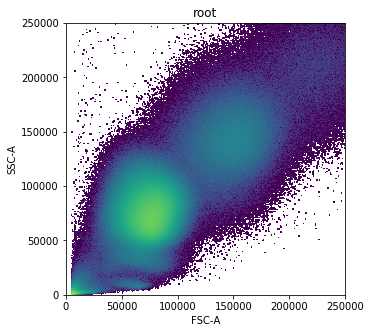

In [72]:
pdn.plotting.plot_population('root', 'FSC-A', 'SSC-A')

In [73]:
child_populations = ChildPopulationCollection('geom')
child_populations.add_population('cells', definition='+')
child_populations.add_population('debris', definition='-')

gate_definition = dict(x='FSC-A', y='SSC-A', x_min=10000, x_max=200000, y_min=5000, y_max=200000,
                      transform_x=None, transform_y=None)
pdn.create_gate(gate_name='boundary_gate', parent='root', class_='Static', method='rect_gate',
                kwargs=gate_definition, child_populations=child_populations)

True

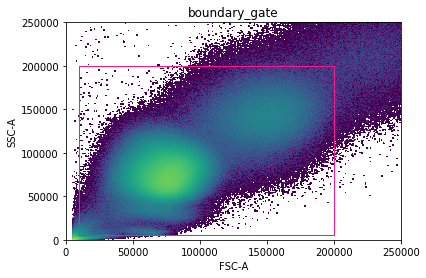

In [74]:
pdn.apply('boundary_gate')

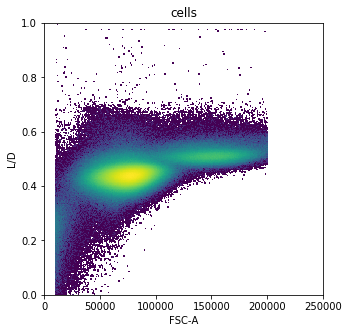

In [75]:
pdn.plotting.plot_population('cells', 'FSC-A', 'L/D', transform_y='logicle')

In [76]:
child_populations = ChildPopulationCollection('geom')
child_populations.add_population('live', definition='+')
child_populations.add_population('dead', definition='-')

gate_definition = dict(x='FSC-A', y='L/D', x_min=10000, x_max=200000, y_min=0, y_max=0.6,
                      transform_x=None)
pdn.create_gate(gate_name='live_gate', parent='cells', class_='Static', method='rect_gate',
                kwargs=gate_definition, child_populations=child_populations)

True

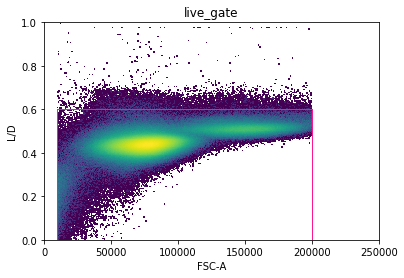

In [77]:
pdn.apply('live_gate')

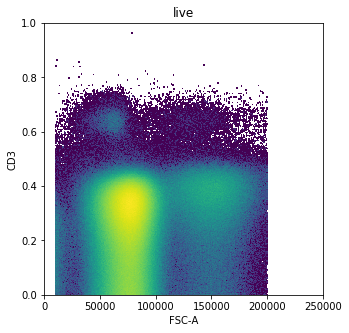

In [78]:
pdn.plotting.plot_population('live', 'FSC-A', 'CD3', transform_y='logicle')

In [79]:
child_populations = ChildPopulationCollection('geom')
child_populations.add_population('CD3-', definition='+')
child_populations.add_population('CD3+', definition='-')

gate_definition = dict(x='FSC-A', y='CD3', x_min=0, x_max=200000, y_min=0, y_max=0.5,
                      transform_x=None)
pdn.create_gate(gate_name='CD3', parent='live', class_='Static', method='rect_gate',
                kwargs=gate_definition, child_populations=child_populations)

True

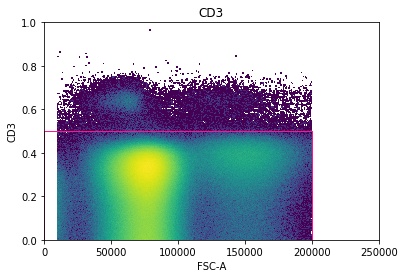

In [80]:
pdn.apply('CD3')

In [81]:
data = pdn.get_population_df('CD3-', transform=True, transform_features='all')

In [82]:
data.shape

(7529295, 18)

In [83]:
data.drop('L/D', axis=1, inplace=True)

In [84]:
data.columns

Index(['FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 'CD14', 'CD16',
       'Siglec-8', 'CD45', 'CD3', 'CD1c', 'CD15', 'HLA-DR', 'CD116', 'CD19',
       'Time'],
      dtype='object')

In [87]:
from sklearn.neighbors import KDTree
from multiprocessing import Pool, cpu_count
from functools import partial
def density_dependent_downsample(data, features: list, frac: float = 0.1, sample_n: int or None = None,
                              alpha: int = 5, mmd_sample_n: int = 2000,
                              outlier_dens: float = 1, target_dens: float = 5):
    def prob_downsample(local_d, target_d, outlier_d):
        if local_d <= outlier_d:
            return 0
        if outlier_d < local_d <= target_d:
            return 1
        if local_d > target_d:
            return target_d / local_d

    df = data.copy()
    mmd_sample = df.sample(mmd_sample_n)
    tree = KDTree(mmd_sample[features], metric='manhattan')
    dist, _ = tree.query(mmd_sample[features], k=2)
    dist = np.median([x[1] for x in dist])
    dist_threshold = dist * alpha
    ld = tree.query_radius(df[features], r=dist_threshold, count_only=True)
    od = np.percentile(ld, q=outlier_dens)
    td = np.percentile(ld, q=target_dens)
    prob_f = partial(prob_downsample, target_d=td, outlier_d=od)
    prob = list(map(lambda x: prob_f(x), ld))
    if sum(prob) == 0:
        print('Error: density dependendent downsampling failed; weights sum to zero. Defaulting to uniform '
              'samplings')
        if sample_n is not None:
            return df.sample(n=sample_n)
        return df.sample(frac=frac)
    if sample_n is not None:
        return df.sample(n=sample_n, weights=prob)
    return df.sample(frac=frac, weights=prob)

In [88]:
sample = density_dependent_downsample(data, features=data.columns, sample_n=200000)

In [89]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(sample)
sample['umap0'] = embedding[:, 0]
sample['umap1'] = embedding[:, 1]

In [94]:
features = [x for x in sample.columns if x not in ['umap0', 'umap1']]
communities, graph, Q = phenograph.cluster(sample[features])

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 122.17111110687256 seconds
Jaccard graph constructed in 12.88972783088684 seconds
Wrote graph to binary file in 10.820125341415405 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.785088
After 3 runs, maximum modularity is Q = 0.787784
After 4 runs, maximum modularity is Q = 0.789726
After 12 runs, maximum modularity is Q = 0.791914
After 17 runs, maximum modularity is Q = 0.793381
Louvain completed 37 runs in 319.8335027694702 seconds
PhenoGraph complete in 466.23737239837646 seconds


In [95]:
sample['cluster'] = communities

In [96]:
len(sample['cluster'].unique())

17

In [97]:
sample = sample[sample.cluster != 14]

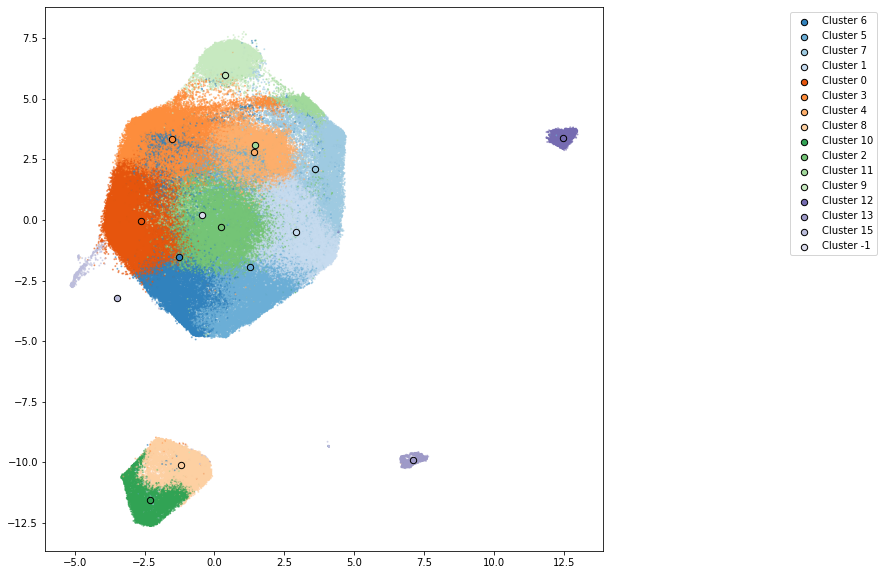

In [98]:
import seaborn as sns
from immunova.flow.gating.utilities import centroid
fig, ax = plt.subplots(figsize=(10,10))
colours = plt.get_cmap('tab20c').colors[0:16]
colour_dict = {k: v for k, v in zip(sample['cluster'].unique(), colours)}
ax.scatter(sample['umap0'],sample['umap1'], 
           s=1, alpha=0.5, c=sample['cluster'].apply(lambda x: colour_dict[x]))
for label, colour in colour_dict.items():
    d = sample[sample['cluster'] == label]
    center = (np.mean(d['umap0']), np.mean(d['umap1']))
    ax.scatter(center[0], center[1], s=40, c=[colour], label=f'Cluster {label}', 
               linewidth=1, edgecolors='black')
leg = ax.legend(loc = 'upper right')
# Get the bounding box of the original legend
bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)

# Change to location of the legend. 
xOffset = 0.5
bb.x0 += xOffset
bb.x1 += xOffset
leg.set_bbox_to_anchor(bb, transform = ax.transAxes)
fig.show()

In [99]:
mfi_summary = sample.groupby(by='cluster').mean()

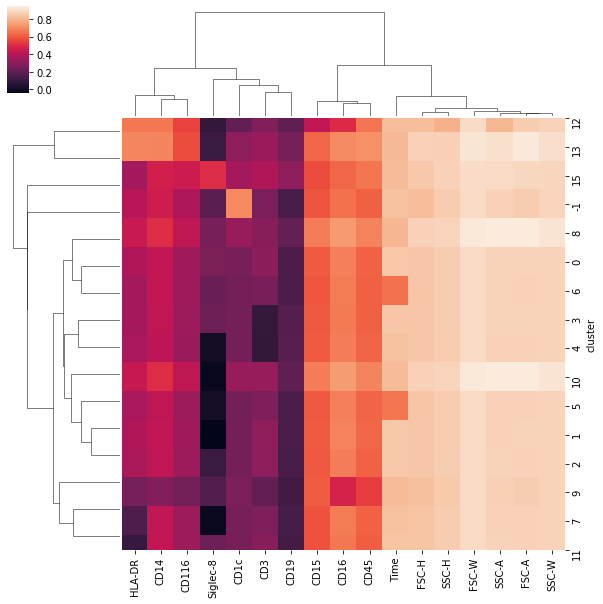

In [100]:
sns.clustermap(mfi_summary[features])

In [101]:
live_cd3['cluster'] = live_cd3['cluster'].apply(lambda x: f't_{x}')
sample['cluster'] = sample['cluster'].apply(lambda x: f'n_{x}')

In [102]:
all_data = pd.concat([live_cd3[['cluster', 'umap0', 'umap1']], sample[['cluster', 'umap0', 'umap1']]])

In [103]:
all_data

,cluster,umap0,umap1
1093,t_10,-0.697007,-6.546343
1145,t_6,12.850671,-0.094413
2540,t_10,-0.798111,-6.564735
2604,t_3,0.625214,4.193702
3173,t_10,0.166316,-7.438584
...,...,...,...
3207686,n_2,-1.176138,0.520770
1275661,n_5,1.922874,-2.490490
951978,n_9,0.938125,6.083983
8891048,n_1,3.128012,-0.718224


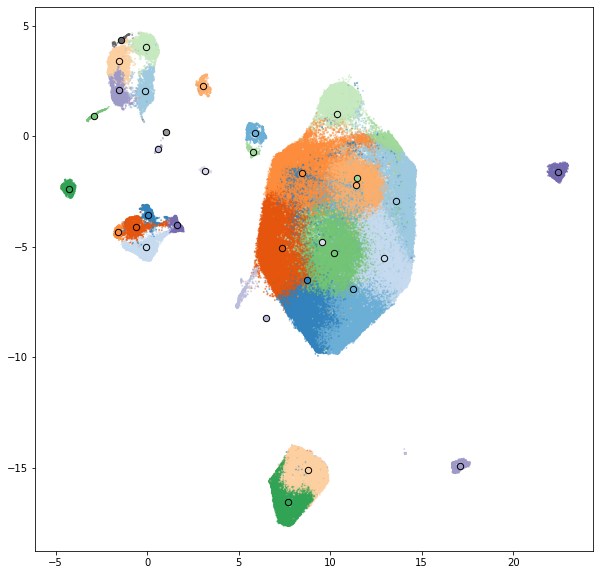

In [119]:
fig, ax = plt.subplots(figsize=(10, 10))
colours = plt.get_cmap('tab20c').colors[0:18]
tcolour_dict = {k: v for k, v in zip(live_cd3['cluster'].unique(), colours)}
colours = plt.get_cmap('tab20c').colors[0:16]
ncolour_dict = {k: v for k, v in zip(sample['cluster'].unique(), colours)}

ax.scatter(sample['umap0']+10,sample['umap1']-5, 
           s=1, alpha=0.5, c=sample['cluster'].apply(lambda x: ncolour_dict[x]))
ax.scatter(live_cd3['umap0']/2,live_cd3['umap1']/2, 
           s=1, alpha=0.5, c=live_cd3['cluster'].apply(lambda x: tcolour_dict[x]))
for label, colour in ncolour_dict.items():
    dn = sample[sample['cluster'] == label]
    center = (np.mean(dn['umap0']+10), np.mean(dn['umap1']-5))
    ax.scatter(center[0], center[1], s=40, c=[colour], label=f'Cluster {label}', 
           linewidth=1, edgecolors='black')
for label, colour in tcolour_dict.items():
    dt = live_cd3[live_cd3['cluster'] == label]
    center = (np.mean(dt['umap0']/2), np.mean(dt['umap1']/2))
    ax.scatter(center[0], center[1], s=40, c=[colour], label=f'Cluster {label}', 
           linewidth=1, edgecolors='black')

leg = ax.legend()
leg.remove()
fig.show()
fig.savefig('Raya_Phenograph.tif', dpi=150)